# Disentanglement Provides a Unified Estimation for Quantum Entropies and Distance Measures (Code)

Myeongjin Shin, Seungwoo Lee, Junseo Lee, Mingyu Lee, Donghwa Ji, Hyeonjun Yeo, Kabgyun Jeong

Paper link: [Arxiv](https://arxiv.org/abs/2401.07716)

This is a code example which reproduces the result on **quantum entropies** in the original paper.

## Environment Setup & Imports

In [1]:
!pip install -q numpy==1.26.4
!pip install -q matplotlib==3.7.1
!pip install -q qiskit==0.46.2
!pip install -q pennylane==0.37
!pip install -q torch==2.4

import csv
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy.linalg import eig, matrix_rank
from qiskit import quantum_info
from torch.autograd import Variable
import pennylane as qml

np.random.seed(40)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 59.9 MB/s eta 0:00:00


## Entropies

von Neumann entropy: $S(\rho) = -\rho \log(\rho)$

Rényi entropy: $S_\alpha(\rho) = \frac{1}{1 - \alpha} \log \textrm{Tr}(\rho^\alpha)$

Tsallis entropy: $S_q(\rho) = \frac{1}{1 - q} (\textrm{Tr}(\rho^q) - 1)$

In [2]:
def von_neumann_entropy(matrix):
    """
    Calculate the von Neumann entropy of a density matrix.

    Args:
    matrix (numpy.ndarray): The density matrix of the quantum state,
                            which is a positive semi-definite Hermitian matrix.

    Returns:
        float: The calculated von Neumann entropy of the given density matrix.
    """

    # Calculate the eigenvalues of the density matrix
    eigs, _ = np.linalg.eig(matrix)
    eigs = np.real(eigs)
    entropy = 0

    # Calculate the von Neumann entropy
    for p in eigs:
        if p < 1e-10:  # Avoid logarithm of zero or negative eigenvalues
            continue
        entropy += -p * math.log(p)

    return entropy


def renyi_entropy(matrix, alpha):
    """
    Calculate the Rényi entropy of a density matrix for a given order alpha.

    Args:
        matrix (numpy.ndarray): The density matrix of the quantum state,
                                which is a positive semi-definite Hermitian matrix.
        alpha (float): The order of the Rényi entropy.
                       For alpha = 1, the Rényi entropy reduces to the Shannon entropy.

    Returns:
        float: The calculated Rényi entropy of the given density matrix.
    """
    if alpha == 1:
        print("alpha should not be 1")
        return None

    # Calculate the eigenvalues of the density matrix
    eigs, _ = np.linalg.eig(matrix)
    eigs = np.real(eigs)
    power_trace = 0

    # Calculate the Rényi entropy
    for p in eigs:
        if p < 1e-10:  # Avoid logarithm of zero or negative eigenvalues
            continue
        power_trace += p ** alpha

    return math.log(power_trace) / (1 - alpha)


def tsallis_entropy(matrix, q):
    """
    Calculate the Tsallis entropy of a density matrix for a given order q.

    Args:
        matrix (numpy.ndarray): The density matrix of the quantum state,
                                which is a positive semi-definite Hermitian matrix.
        q (float): The order of the Tsallis entropy

    Returns:
        float: The calculated Tsallis entropy of the given density matrix.
    """
    if q == 1:
        print("q should not be 1")
        return None

    # Calculate the eigenvalues of the density matrix
    eigs, _ = np.linalg.eig(matrix)
    eigs = np.real(eigs)
    power_trace = 0

    # Calculate the Tsallis entropy
    for p in eigs:
        if p < 1e-10:  # Ignore very small or negative eigenvalues
            continue
        power_trace += p ** q

    return (power_trace - 1) / (1 - q)

## Preparing States $\rho_{AB}$

To prepare a density matrix $\rho_{AB}$ of random (probably mixed) state of ```num_qubits```, we prepare a pure state of ```unitary_qubits``` and calculate partial trace.

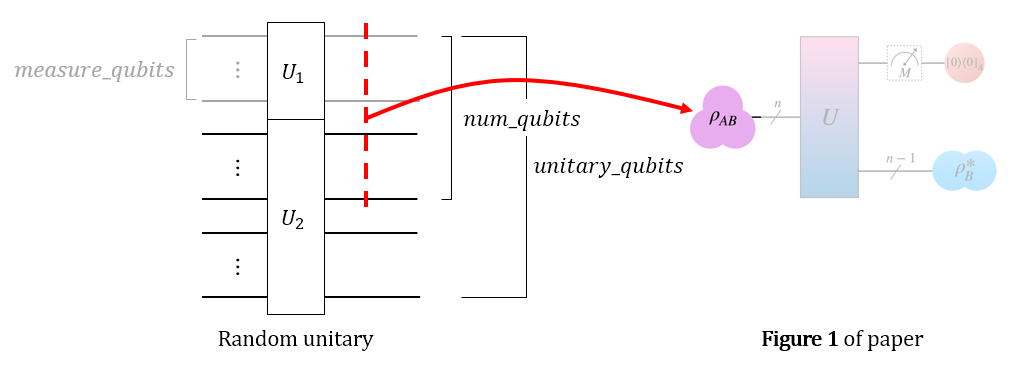

In [12]:
num_qubits = 6
measure_qubits = 3
unitary_qubits = 2 * num_qubits - measure_qubits

unitary = None
input_state = None

# Generating random pure state consisting of "unitary_qubits".
U1 = quantum_info.random_unitary(dims=2 ** (measure_qubits), seed=10+i).data
U2 = quantum_info.random_unitary(dims=2 ** (unitary_qubits - measure_qubits), seed=20+i).data
unitary = np.kron(U1, U2)  # A random unitary matrix.

dev = qml.device("default.qubit", wires=unitary_qubits)
mixed_dev = qml.device("default.mixed", wires=num_qubits)

def init(unitary):
    qml.QubitUnitary(unitary, wires=[i for i in range(unitary_qubits)])

@qml.qnode(dev)
def density_matrix(unitary, a, b):
    init(unitary)
    return qml.density_matrix(wires=[i for i in range(a, b)])  # Calculate partial trace

# Get partial trace to get a mixed state consisting of "num_qubits".
input_state = np.array(density_matrix(unitary, 0, num_qubits))  # Input state rho_AB.

In [13]:
print(unitary.shape)  # (2 ** unitary_qubits, 2 ** unitary_qubits)
print(input_state.shape)   # (2 ** num_qubits, 2 ** num_qubits)

(512, 512)
(64, 64)


## Circuit Ansatz

An ansatz to optimize consists of several layers, where each layer has 3 rotation gate for X, Y, Z direction and CNOT gates between the adjacent qubits. The code below implements the following structure.

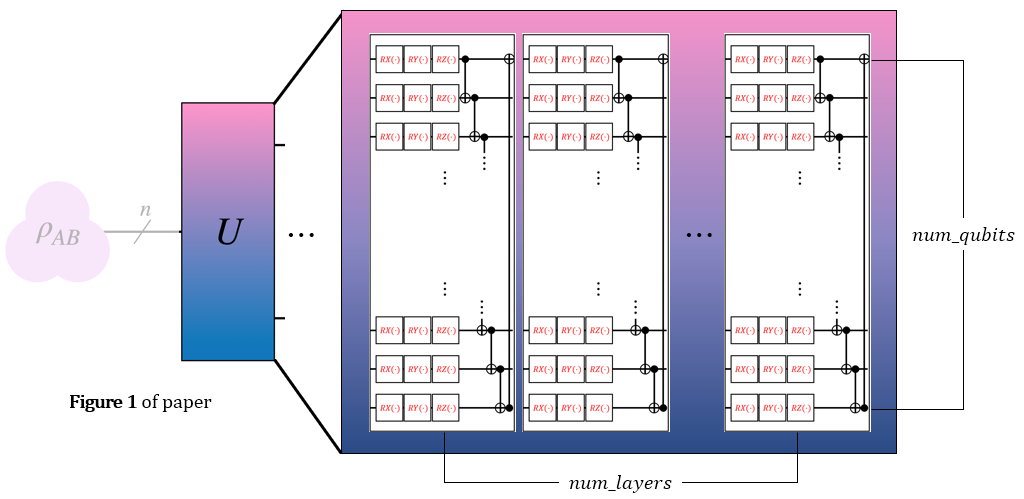

This parameterized unitary, which is DEQNN, stores its parameter as 3-dimensional tensor ```params```. ```params[i][j]``` has rotation angle toward X, Y, and Z direction applied to i-th qubit of j-th layer.

In [14]:
def layer(params, j, n_qubits):
    """
    A layer of DEQNN.
    The detailed structure of a layer is described above.
    """

    for i in range(n_qubits):
        qml.RX(params[i, j, 0], wires=i)
        qml.RY(params[i, j, 1], wires=i)
        qml.RZ(params[i, j, 2], wires=i)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])


def DEQNN(params, num_layers):
    """
    Run DEQNN, which is applying layers sequentially.
    The detailed structure of DEQNN is described above.
    """
    for j in range(num_layers):
        layer(params, j, num_qubits)


@qml.qnode(dev)
def circuit_matrix(U, params, num_layers, a, b):
    """
    Given an initial unitary, run DEQNN and returns a density matrix from a-th qubit to (b-1)-th qubit.
    """

    # Prepare initial pure unitary
    init(U)

    # Run DEQNN
    DEQNN(params, num_layers)

    # Return density matrix of the subsystem
    return qml.density_matrix(wires=[i for i in range(a, b)])


@qml.qnode(mixed_dev, interface="torch")
def loss_fn(matrix, params, num_layers):
    """
    A loss function of DEQNN,
    Given a density matrix, run the circuit and conduct observation, which is projection to the |0> basis.
    It gives the probability of observing 0 on the "measure_qubits".
    """

    # Prepare initial density matrix
    qml.QubitDensityMatrix(matrix, wires=[i for i in range(num_qubits)])

    # Run DEQNN
    DEQNN(params, num_layers)

    # Project to |0> basis to get the probability of getting 0 for all measure_qubits.
    observable = torch.zeros([2 ** measure_qubits, 2 ** measure_qubits])
    observable[0][0] = 1.0

    return qml.expval(qml.Hermitian(observable, wires=range(measure_qubits)))

Note that our loss function of DEQNN is independent to the property we want to estimate.

## Training DEQNN

In our implementation of DEQNN, we use 40 layers.

In [9]:
# Entropies to estimate
alpha = 1.5  # Renyi entropy
q = 1.5  # Tsallis entropy

# Parameters of DEQNN
num_layers = 40
qnn_params = np.random.normal(0, 2 * np.pi, (num_qubits, num_layers, 3))
qnn_params = Variable(torch.tensor(qnn_params), requires_grad=True)

First, we calculate the entropies of original state (ground-truth) and the entropies of the state after applying DEQNN before any optimization.

In [15]:
# Ground truth
von_neumann_gt = von_neumann_entropy(input_state)
renyi_gt = renyi_entropy(input_state, alpha)
tsallis_gt = tsallis_entropy(input_state, q)

print(f"Ground-truth von Neumann entropy: {von_neumann_gt}")
print(f"Ground-truth Renyi entropy where alpha = {alpha}: {renyi_gt}")
print(f"Ground-truth Tsallis entropy where q = {q}: {tsallis_gt}")

Ground-truth von Neumann entropy: 1.5490765913481912
Ground-truth Renyi entropy where alpha = 1.5: 1.4369365891110164
Ground-truth Tsallis entropy where q = 1.5: 1.025003223355663


In [17]:
# Estimated value
von_neumann_est = []
renyi_est = []
tsallis_est = []

m = circuit_matrix(unitary, qnn_params, num_layers, measure_qubits, num_qubits).detach().numpy()

# Calculate each entropies
von_neumann_est.append(von_neumann_entropy(m))
renyi_est.append(renyi_entropy(m, alpha))
tsallis_est.append(tsallis_entropy(m, q))

# Calculate loss
purity = loss_fn(input_state, qnn_params, num_layers)
loss = 1 - purity

print(f'Loss after 0 steps: {loss}')
print(f"Estimated von Neumann entropy: {von_neumann_est[-1]}")
print(f"Estimated Renyi entropy where alpha = {alpha}: {renyi_est[-1]}")
print(f"Estimated Tsallis entropy where q = {q}: {tsallis_est[-1]}")

Loss after 0 steps: 0.8537608396051731
Estimated von Neumann entropy: 1.940877665855584
Estimated Renyi entropy where alpha = 1.5: 1.8825559472852653
Estimated Tsallis entropy where q = 1.5: 1.2197421157301012


Now, optimize DEQNN to preserve each entropies.

In [18]:
optimizer = torch.optim.Adam([qnn_params], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

steps = 500
for n in range(steps):
    optimizer.zero_grad()
    purity = loss_fn(input_state, qnn_params, num_layers)
    loss = 1 - purity
    loss.backward()
    optimizer.step()

    # Run DEQNN and get the resulting density matrix
    m = circuit_matrix(unitary, qnn_params, num_layers, measure_qubits, num_qubits).detach().numpy()

    # Calculate entropies
    von_neumann_est.append(von_neumann_entropy(m))
    renyi_est.append(renyi_entropy(m, alpha))
    tsallis_est.append(tsallis_entropy(m, q))

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print(f'Loss after {n + 1} steps: {loss}')
        print(f"Estimated von Neumann entropy: {von_neumann_est[-1]}")
        print(f"Estimated Renyi entropy where alpha = {alpha}: {renyi_est[-1]}")
        print(f"Estimated Tsallis entropy where q = {q}: {tsallis_est[-1]}")
        print()

Loss after 10 steps: 0.31760282151288055
Estimated von Neumann entropy: 1.6797799720408095
Estimated Renyi entropy where alpha = 1.5: 1.5339849430401908
Estimated Tsallis entropy where q = 1.5: 1.0711846211382237

Loss after 20 steps: 0.17366236137321855
Estimated von Neumann entropy: 1.5848564467371544
Estimated Renyi entropy where alpha = 1.5: 1.4439021714991105
Estimated Tsallis entropy where q = 1.5: 1.0283930271277413

Loss after 30 steps: 0.10604460837826146
Estimated von Neumann entropy: 1.5404608472046988
Estimated Renyi entropy where alpha = 1.5: 1.4138483889269688
Estimated Tsallis entropy where q = 1.5: 1.0136825451774258

Loss after 40 steps: 0.07288210063897327
Estimated von Neumann entropy: 1.5294756448215823
Estimated Renyi entropy where alpha = 1.5: 1.410885114964726
Estimated Tsallis entropy where q = 1.5: 1.0122200976205797

Loss after 50 steps: 0.0549076066521752
Estimated von Neumann entropy: 1.5240412907514151
Estimated Renyi entropy where alpha = 1.5: 1.4103991735

KeyboardInterrupt: 